In [1]:
import pandas as pd
import numpy as np
from pybdm import BDM
from pybdm import PartitionRecursive
from statistics import harmonic_mean,geometric_mean
import seaborn as sns
from joblib import delayed, Parallel
import altair as alt

In [2]:
#exp_path = "seriesWithLLMs_ext.csv"
# update at Aug 3th 2025
exp_path = "seriesWithLLMs_ext_Aug2025.csv"
bin_seq_df_input = pd.read_csv(exp_path)
bin_seq_df_input

,sequence,chatgpt_4.5-formula,chatgpt_4.5-formula-eval,chatgpt_4.5-formula-correctness,chatgpt_4.5-formula-copy_seq,chatgpt_4.5-formula-ordinal,deepseek-formula,deepseek-formula-eval,deepseek-formula-correctness,deepseek-formula-copy_seq,...,llama_4_scout-program-correctness,chatgpt_5-formula,chatgpt_5-formula-eval,chatgpt_5-formula-correctness,chatgpt_5-formula-copy_seq,chatgpt_5-formula-ordinal,chatgpt_5-program,chatgpt_5-program-eval,chatgpt_5-program-print,chatgpt_5-program-correctness
0,"1,1,0,0,0,1,0,0,0,0,1,0","[""[int(i in [0,1,5,10]) for i in range(12)]"",""...","1,1,0,0,0,1,0,0,0,0,1,0",True,False,True,"[1,1,0,0,0,1,0,0,0,0,1,0]","1,1,0,0,0,1,0,0,0,0,1,0",True,True,...,True,"a_n = 1 if n mod 12 in {1,2,6,11} else 0","0,1,1,0,0,0,1,0,0,0,0,1",False,False,True,"print([1,1,0,0,0,1,0,0,0,0,1,0])","1,1,0,0,0,1,0,0,0,0,1,0",True,True
1,"0,0,0,1,0,1,1,0,1,0,1,1","[""[int(i in [3,5,6,8,10,11]) for i in range(12...","0,0,0,1,0,1,1,0,1,0,1,1",True,False,True,"[0,0,0,1,0,1,1,0,1,0,1,1]","0,0,0,1,0,1,1,0,1,0,1,1",True,True,...,True,"a_n = 1 if n mod 12 in {4,6,7,9,11,12} else 0","0,0,0,0,1,0,1,1,0,1,0,1",False,False,True,"print([0,0,0,1,0,1,1,0,1,0,1,1])","0,0,0,1,0,1,1,0,1,0,1,1",True,True
2,"1,0,0,0,0,1,1,1,1,0,0,1","[""[int(i in [0,5,6,7,8,11]) for i in range(12)...","1,0,0,0,0,1,1,1,1,0,0,1",True,False,True,"[1,0,0,0,0,1,1,1,1,0,0,1]","1,0,0,0,0,1,1,1,1,0,0,1",True,True,...,True,"a_n = 1 if n mod 12 in {1,6,7,8,9,12} else 0","0,1,0,0,0,0,1,1,1,1,0,0",False,False,True,"print([1,0,0,0,0,1,1,1,1,0,0,1])","1,0,0,0,0,1,1,1,1,0,0,1",True,True
3,"1,1,1,1,1,1,1,1,0,1,0,0","[""[int(i<8 or i==9) for i in range(12)]"",""[1]*...","1,1,1,1,1,1,1,1,0,1,0,0",True,False,True,"[1,1,1,1,1,1,1,1,0,1,0,0]","1,1,1,1,1,1,1,1,0,1,0,0",True,True,...,True,"a_n = 1 if n mod 12 in {1,2,3,4,5,6,7,8,10} el...","0,1,1,1,1,1,1,1,0,0,1,0",False,False,True,"print([1,1,1,1,1,1,1,1,0,1,0,0])","1,1,1,1,1,1,1,1,0,1,0,0",True,True
4,"1,0,1,1,0,1,0,1,0,1,0,0","[""[int(i in [0,2,3,5,7,9]) for i in range(12)]...","1,0,1,1,0,1,0,1,0,1,0,0",True,False,True,"[1,0,1,1,0,1,0,1,0,1,0,0]","1,0,1,1,0,1,0,1,0,1,0,0",True,True,...,True,"a_n = 1 if n mod 12 in {1,3,4,6,8,10} else 0","0,1,0,1,1,0,1,0,1,0,1,0",False,False,True,"print([1,0,1,1,0,1,0,1,0,1,0,0])","1,0,1,1,0,1,0,1,0,1,0,0",True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,"187,218,260,295,301,000,000,000,000,000",***,***,False,False,False,***,***,False,False,...,False,not found,not found,False,False,False,*not found,*not found,False,False
186,"29,63,95,140,150,190,221,437,482,491",***,***,False,False,False,***,***,False,False,...,False,not found,not found,False,False,False,*not found,*not found,False,False
187,"3,11,84,144,156,177,188,199,229,284",***,***,False,False,False,***,***,False,False,...,False,not found,not found,False,False,False,*not found,*not found,False,False
188,"26,94,98,137,176,301,323,330,372,444",***,***,False,False,False,***,***,False,False,...,False,not found,not found,False,False,False,*not found,*not found,False,False


In [3]:
bin_seqs = bin_seq_df_input.iloc[:100,:]
int_seqs_1 = bin_seq_df_input.iloc[100:130,:]
int_seqs_2 = bin_seq_df_input.iloc[130:160,:]
int_seqs_3 = bin_seq_df_input.iloc[160:,:]

In [4]:
bin_seq_df=bin_seqs

In [5]:
# new models added at Aug 2025

models = ['gpt_4o', 'claude_3.5', 'gpt_4o_mini', 'cursor_small', 'gemini', 'meta', 
          'o1_mini', 'o1_preview', 'mistral', 'qwen', 'grok_3', 'deepseek', 'claude_3.7', 'chatgpt_4.5',
          'opus_4', 'claude_sonnet_4', 'gemini_2.5_pro', 'mistral_large2405', 'qwen3', 'deepseek_r1_0528',
          'grok4', 'llama_4_scout', "chatgpt_5"]#,'BDM/CTM']

In [6]:
def ascii_to_binary_list(text):
    binary_list = []
    for char in text:
        # Convert each character to its binary representation
        binary_representation = format(ord(char), '08b')
        # Extend the binary_list with the numerical digits of the binary representation
        binary_list.extend([int(bit) for bit in binary_representation])
    return np.array(binary_list).astype(np.int8)


In [7]:
def tst_calc(v1,v2):
    v3 = (v2)*np.array([1,0.1,0.01])
    return np.sum(v1[:3]*v3)


def process_sequence(seq_str):
    """
    Process a sequence string to prepare it for BDM calculation.
    - If it's already a binary sequence (0s and 1s), split by commas and convert to int8
    - If it's a numeric sequence, convert each number to binary digits and flatten
    """
    elements = seq_str.split(",")
    # Check if all elements are binary (0 or 1)
    is_binary = all(e.strip() in ['0', '1'] for e in elements)
    
    if is_binary:
        # Already binary, just convert to int8 array
        return np.array(elements).astype(np.int8)
    else:
        # Convert numeric sequence to binary representation
        binary_digits = []
        for num in elements:
            try:
                # Convert to integer and then to binary string (removing '0b' prefix)
                bin_str = bin(int(num.strip()))[2:]
                # Convert each binary digit to int and add to list
                binary_digits.extend([int(digit) for digit in bin_str])
            except ValueError:
                # If conversion fails, use empty list
                pass
        return np.array(binary_digits).astype(np.int8)
    
test_vals=[]
bdm = BDM(ndim=1,partition=PartitionRecursive)
for mdl in models:#[:-1]:
    print('processing model: ', mdl)
    sep_df= bin_seq_df[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()
    sep_df["bdm_formula"]=[bdm.nbdm(ascii_to_binary_list(x)) for x in sep_df[f'{mdl}-formula'].to_numpy()]
    sep_df["bdm_input"]=[bdm.nbdm(ascii_to_binary_list(x)) for x in sep_df['sequence'].to_numpy()]
    
    df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
    df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
    df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
    df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
    tot_elements = np.sum([len(x) for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
    v1=np.array([len(x)/tot_elements for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
    v2 = []
    for x in [df_c_n_n,df_c_o,df_c_p]:
        datax = np.tanh(((x["bdm_input"])/(x["bdm_formula"])).to_numpy())
        if len(datax)>0:
            v2.append(harmonic_mean(datax))
        else:
            v2.append(0)
    v2 = (np.nan_to_num(np.array(v2)))
    tst = tst_calc(v1,v2)
    test_vals.append([mdl]+list(v1)+list(v2)+[tst])

processing model:  gpt_4o
processing model:  claude_3.5
processing model:  gpt_4o_mini
processing model:  cursor_small
processing model:  gemini
processing model:  meta
processing model:  o1_mini
processing model:  o1_preview
processing model:  mistral
processing model:  qwen
processing model:  grok_3
processing model:  deepseek
processing model:  claude_3.7
processing model:  chatgpt_4.5
processing model:  opus_4
processing model:  claude_sonnet_4
processing model:  gemini_2.5_pro
processing model:  mistral_large2405
processing model:  qwen3
processing model:  deepseek_r1_0528
processing model:  grok4
processing model:  llama_4_scout
processing model:  chatgpt_5


In [8]:


df_ranking = pd.DataFrame(test_vals)
df_ranking.columns = ["Model","p1","p2","p3","p4","r1","r2","r3","tst"]
np.round(df_ranking.sort_values(by=['tst'],ascending=False).set_index(["Model"]),3)



,p1,p2,p3,p4,r1,r2,r3,tst
Model,,,,,,,,
chatgpt_4.5,0.00,1.00,0.0,0.00,0.000,0.419,0.000,0.042
o1_mini,0.00,0.64,0.0,0.36,0.000,0.537,0.000,0.034
claude_3.7,0.00,0.81,0.0,0.19,0.000,0.407,0.000,0.033
claude_3.5,0.06,0.14,0.0,0.80,0.449,0.428,0.000,0.033
o1_preview,0.00,0.29,0.0,0.71,0.000,0.423,0.000,0.012
gpt_4o_mini,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
cursor_small,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
gemini,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
deepseek,0.00,0.00,1.0,0.00,0.000,0.000,0.710,0.007


In [9]:
df_ranking = pd.DataFrame(test_vals)
df_ranking.columns = ["Model","p1","p2","p3","p4","r1","r2","r3","tst"]
np.round(df_ranking.sort_values(by=['tst'],ascending=False).set_index(["Model"]),3)

,p1,p2,p3,p4,r1,r2,r3,tst
Model,,,,,,,,
chatgpt_4.5,0.00,1.00,0.0,0.00,0.000,0.419,0.000,0.042
o1_mini,0.00,0.64,0.0,0.36,0.000,0.537,0.000,0.034
claude_3.7,0.00,0.81,0.0,0.19,0.000,0.407,0.000,0.033
claude_3.5,0.06,0.14,0.0,0.80,0.449,0.428,0.000,0.033
o1_preview,0.00,0.29,0.0,0.71,0.000,0.423,0.000,0.012
gpt_4o_mini,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
cursor_small,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
gemini,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
deepseek,0.00,0.00,1.0,0.00,0.000,0.000,0.710,0.007


### Append ASI

In [10]:
new_row = {'Model': 'ASI', 'p1': 1, 'p2': 0, 'p3': 0, 'p4': 0, 'r1': 1, 'r2': 0, 'r3': 1, 'tst': 1}
df_ranking2 = pd.concat([df_ranking, pd.DataFrame([new_row])], ignore_index=True)
df_ranking2 = df_ranking2.sort_values(by='tst', ascending=False)
np.round(df_ranking2,3)

,Model,p1,p2,p3,p4,r1,r2,r3,tst
23,ASI,1.00,0.00,0.0,0.00,1.000,0.000,1.000,1.000
13,chatgpt_4.5,0.00,1.00,0.0,0.00,0.000,0.419,0.000,0.042
6,o1_mini,0.00,0.64,0.0,0.36,0.000,0.537,0.000,0.034
12,claude_3.7,0.00,0.81,0.0,0.19,0.000,0.407,0.000,0.033
1,claude_3.5,0.06,0.14,0.0,0.80,0.449,0.428,0.000,0.033
7,o1_preview,0.00,0.29,0.0,0.71,0.000,0.423,0.000,0.012
4,gemini,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
3,cursor_small,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
2,gpt_4o_mini,0.00,0.00,1.0,0.00,0.000,0.000,0.762,0.008
8,mistral,0.00,0.00,1.0,0.00,0.000,0.000,0.710,0.007


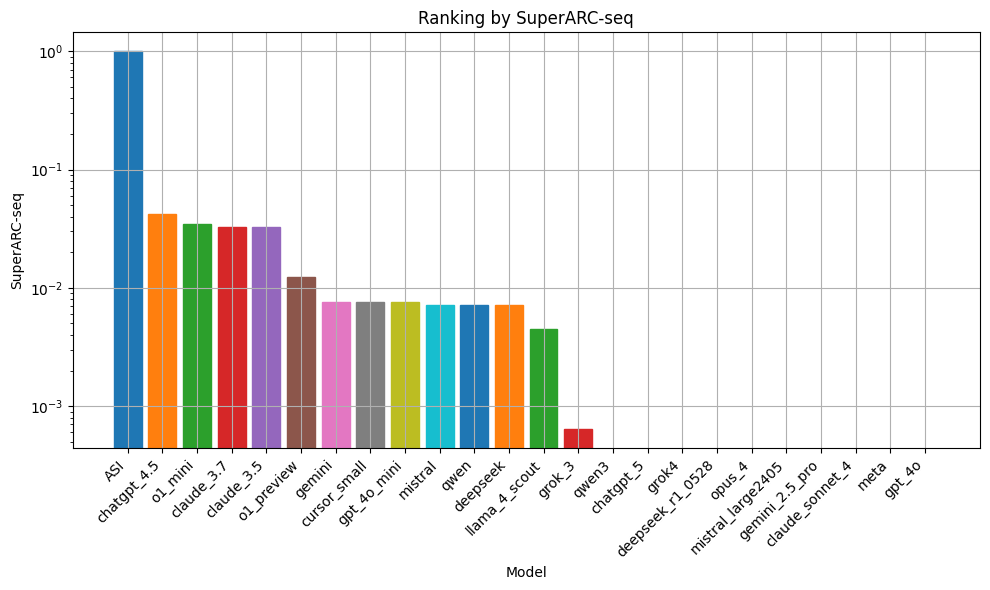

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Sort values in descending order
sorted_df = df_ranking2.sort_values('tst', ascending=False)
# Create bar plot using Model column with default color cycle
bars = plt.bar(range(len(sorted_df)), sorted_df['tst'])
# Set different colors for each bar using default color cycle
for i, bar in enumerate(bars):
    bar.set_color(f'C{i}')
plt.grid(True)
plt.title('Ranking by SuperARC-seq')
plt.xlabel('Model')
plt.ylabel('SuperARC-seq')
# Set y-axis to log scale
plt.yscale('log')
# Set x-tick labels with model names
plt.xticks(range(len(sorted_df)), sorted_df['Model'], rotation=45, ha='right')
plt.tight_layout()
plt.show()

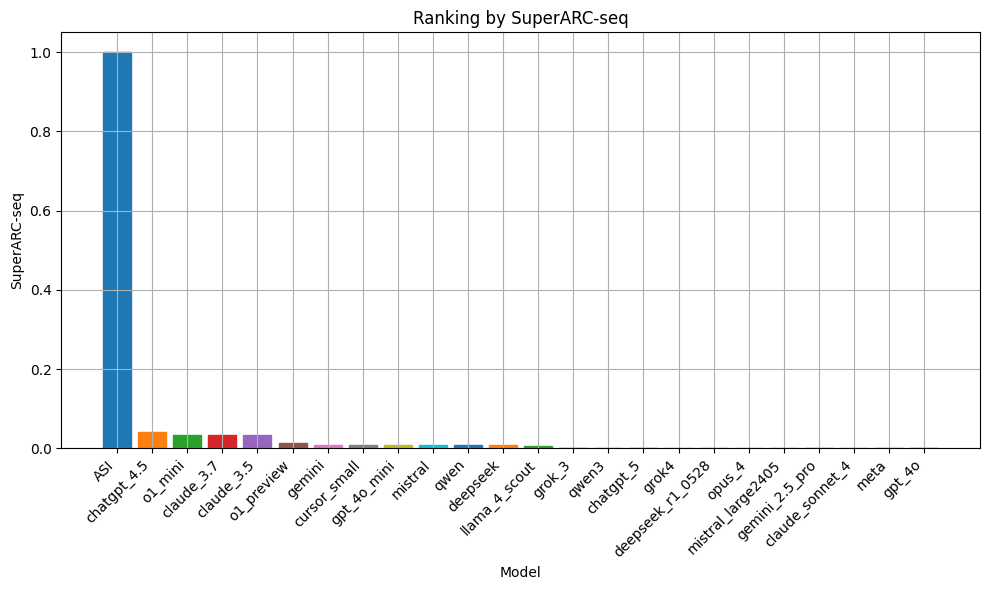

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Sort values in descending order
sorted_df = df_ranking2.sort_values('tst', ascending=False)
# Create bar plot using Model column with default color cycle
bars = plt.bar(range(len(sorted_df)), sorted_df['tst'])
# Set different colors for each bar using default color cycle
for i, bar in enumerate(bars):
    bar.set_color(f'C{i}')
plt.grid(True)
plt.title('Ranking by SuperARC-seq')
plt.xlabel('Model')
plt.ylabel('SuperARC-seq')

# Set x-tick labels with model names
plt.xticks(range(len(sorted_df)), sorted_df['Model'], rotation=45, ha='right')
plt.tight_layout()
# plt.savefig("rankingSuperARC.png", bbox_inches='tight',dpi=600)
plt.show()



In [13]:
def inner_loop_function(models,bin_seq_df):
    bdm = BDM(ndim=1,partition=PartitionRecursive)
    dict_tst={}
    for mdl in models:#[:-1]:
        sep_df= bin_seq_df[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()
        sep_df["bdm_formula"]=[bdm.nbdm(ascii_to_binary_list(x)) for x in sep_df[f'{mdl}-formula'].to_numpy()]
        sep_df["bdm_input"]=[bdm.nbdm(ascii_to_binary_list(x)) for x in sep_df['sequence'].to_numpy()]

        df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
        df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
        df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
        df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
        tot_elements = np.sum([len(x) for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
        v1=np.array([len(x)/tot_elements for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
        v2 = []
        for x in [df_c_n_n,df_c_o,df_c_p]:
            datax = np.tanh(((x["bdm_input"])/(x["bdm_formula"])).to_numpy())
            if len(datax)>0:
                v2.append(harmonic_mean(datax))
            else:
                v2.append(0)
        v2 = (np.nan_to_num(np.array(v2)))
        tst = tst_calc(v1,v2)
        dict_tst[mdl] = [tst]
    return dict_tst

In [14]:
np.random.seed(42)
rng = np.random.default_rng()

tst_bootstrap=[]
for sz in [25,50,75,100]:
    inpts_bts = []
    for rep_id in range(100):
        idx_v = rng.integers(low=0, high=100, size=sz,dtype = int)
        inpts_bts.append([models,bin_seqs.iloc[idx_v]])

    calcs_lst = Parallel(n_jobs=32)(delayed(inner_loop_function)(*x) for x in inpts_bts)
    dict_tst={}
    for mdl in models:
        dict_tst[mdl]=[]
    for dict_indiv in calcs_lst:
        for ddd in dict_indiv.keys():
            dict_tst[ddd]=dict_tst[ddd]+dict_indiv[ddd]
    tst_bootstrap.append(dict_tst)

In [15]:
lst_dfs=[]
for pp,sz in enumerate([25,50,75,100]): 
    df_interm = pd.DataFrame(tst_bootstrap[pp]).T.reset_index()
    df_interm = df_interm.melt(id_vars=['index'])
    df_interm.loc[:,'variable']=sz
    lst_dfs.append(df_interm)
df_bts = pd.concat(lst_dfs)
df_bts.columns = ["Model","# of Sequences","Test Score"]

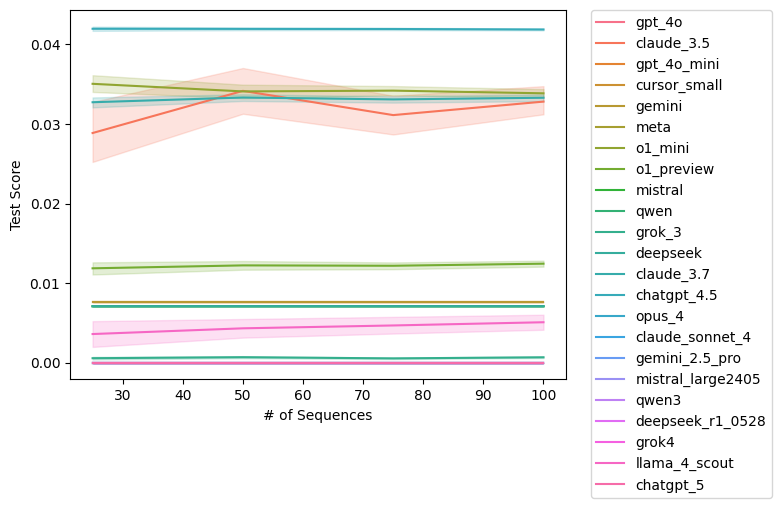

In [16]:
line_plot = sns.lineplot(data=df_bts, x="# of Sequences", y="Test Score", hue="Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# plt.savefig("robustness_tst.png", bbox_inches='tight',dpi=600)

In [17]:
dfs_study = [bin_seqs, int_seqs_1, int_seqs_2, int_seqs_3]
labels_study = ["Binary", "Integers Type 1","Integers Type 2","Integers Type 3"]

In [18]:
test_vals=[]
bdm = BDM(ndim=1,partition=PartitionRecursive)
for ll,dd in zip(labels_study,dfs_study):  
    for mdl in models:
        sep_df= dd[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()

        df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
        df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
        df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
        df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
        tot_elements = np.sum([len(x) for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
        v1=np.array([len(x)/tot_elements for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
        test_vals.append([mdl]+list(v1)+[ll])

In [19]:
df_stack = pd.DataFrame(test_vals,columns = ["Model","p1","p2","p3","p4","Type"]);

In [20]:
dfs_altair=[]
for pp in ["p1","p2","p3","p4"]:
    df_filt_stack = df_stack.loc[:,pp].to_numpy()
    num_models = len(models)
    df_itermv = pd.DataFrame(df_filt_stack.reshape(len(df_filt_stack)//num_models, num_models, order='F')).T   
    df_itermv.index = models
    df_itermv.columns = labels_study
    dfs_altair.append(df_itermv)

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['Prob'] = name
    return df

lst_final_df = []
for pp,nm in enumerate(["p₁","p₂","p₃","p₄"]):
    lst_final_df.append(prep_df(dfs_altair[pp], nm))

df_final = pd.concat(lst_final_df,ignore_index=True)

In [21]:
alt.Chart(df_final[[x in models[7:] for x in df_final['c1'].to_numpy()]]).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False,
            title=None)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Prob:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#96ceb4', '#ffcc5c','#ff6f69','#da680f'],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )



alt.Chart(...)

In [22]:
test_vals_2=[]
bdm = BDM(ndim=1,partition=PartitionRecursive)
for ll,dd in zip(labels_study,dfs_study):  
    for mdl in models:
        sep_df= dd[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()

        sep_df["bdm_formula"]=[bdm.nbdm(ascii_to_binary_list(x)) for x in sep_df[f'{mdl}-formula'].to_numpy()]
        sep_df["bdm_input"]=[bdm.nbdm(ascii_to_binary_list(x)) for x in sep_df['sequence'].to_numpy()]

        df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
        df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
        df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
        df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
        tot_elements = np.sum([len(x) for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
        v1=np.array([len(x)/tot_elements for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
        v2 = []
        for x in [df_c_n_n,df_c_o,df_c_p]:
            datax = np.tanh(((x["bdm_input"])/(x["bdm_formula"])).to_numpy())
            if len(datax)>0:
                v2.append(harmonic_mean(datax))
            else:
                v2.append(0)
        v2 = (np.nan_to_num(np.array(v2)))
        tst = tst_calc(v1,v2)
        test_vals_2.append([mdl]+list(v2)+[tst,ll])

In [23]:
df_stack_2 = pd.DataFrame(test_vals_2,columns = ["Model","r1","r2","r3","tst","Type"]);

In [24]:
dfs_altair_2=[]
for pp in ["tst"]:
    df_filt_stack = df_stack_2.loc[:,pp].to_numpy()
    num_models = len(models)
    df_itermv = pd.DataFrame(df_filt_stack.reshape(len(df_filt_stack)//num_models, num_models)).T
    df_itermv.index = models
    df_itermv.columns = labels_study
    dfs_altair_2.append(df_itermv)

def prep_df(df, name):
    df = df.stack().reset_index()
    df.columns = ['c1', 'c2', 'values']
    df['Metric'] = name
    return df

lst_final_df_2 = []
for pp,nm in enumerate(["𝜑"]):
    lst_final_df_2.append(prep_df(dfs_altair_2[pp], nm))

df_final_2 = pd.concat(lst_final_df_2,ignore_index=True)

In [25]:
alt.Chart(df_final_2[[x in models[:7] for x in df_final_2['c1'].to_numpy()]]).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False,
            title=None)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Metric:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#96ceb4', '#ffcc5c','#ff6f69','#da680f'],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )

alt.Chart(...)

In [26]:
alt.Chart(df_final_2[[x in models[7:] for x in df_final_2['c1'].to_numpy()]]).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('c2:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(values):Q',
        axis=alt.Axis(
            grid=False,
            title=None)),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('c1:N', title=None),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Metric:N',
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['#96ceb4', '#ffcc5c','#ff6f69','#da680f'],
            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0    
    )

alt.Chart(...)